In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ttest_ind
from scipy.spatial import distance

In [4]:
#Load data
X = np.loadtxt('Zeisel_expr.txt').T
genes = np.loadtxt('Zeisel_genes.txt', delimiter='\n', dtype=str)
labels = np.loadtxt('Zeisel_labels.txt', delimiter='\n', dtype=str)


In [5]:
#Useful Python-style tricks for working with the data:

#Trick 1
#You often want to slice the count matrix X to obtain only cells for a particular cell type (label).
#One common use case is that you want to plot cells of each type with a distinct color.
#Python supports condition-style boolean slicing which makes these kinds of queries easy.
#For example, the below code selects only the Astrocytes cells (subset of rows).

X_Astrocytes = X[labels == 'Astrocytes', :]

#Trick 2
#Sometimes you need to filter multiple arrays based on some condition.
#Then you typically need to store the boolean condition as a separate variable.
#For example, the below code filters both 'X' and 'genes' to get only genes whose name starts with a T.

T_filter = np.array([gene[0] == 'T' for gene in genes.tolist()])

genes_T = genes[T_filter]
X_T = X[:, T_filter]

#Trick 3
#Sometimes you need to sort an array based on the values of some other array.
#numpy has a good argsort function to accomplish this
#For example, the below code sorts 'genes' based on total read count across all cells

gene_sort_index = np.argsort(np.sum(X, axis=0))
genes_sorted = genes[gene_sort_index]


Number of cells: 3005
Number of genes: 19972
Avg count: 0.698810264486754
Max count: 10738.0


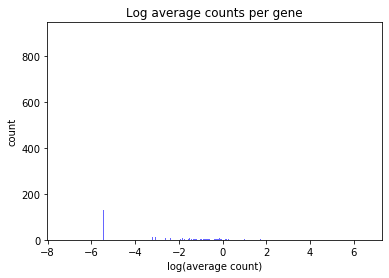

In [6]:
#Problem 2.1 Single-cell stats

#a) TODO: Calculate number of cells and number of genes
print("Number of cells: " + str(len(X)))
print("Number of genes: " + str(len(X[0])))

#b) TODO: Calculate average and maximum count over all cells and genes
print("Avg count: " + str(np.average(X)))
print("Max count: " + str(np.max(X)))

#c) TODO: Plot log(average count) for each gene over cells (the average is taken over cells) as a histogram
avgs = np.log(np.average(X, axis=0))

n, bins, patches = plt.hist(avgs, bins=len(avgs), facecolor='blue', alpha=0.6)

plt.xlabel('log(average count)')
plt.ylabel('count');
plt.title('Log average counts per gene')
plt.show()


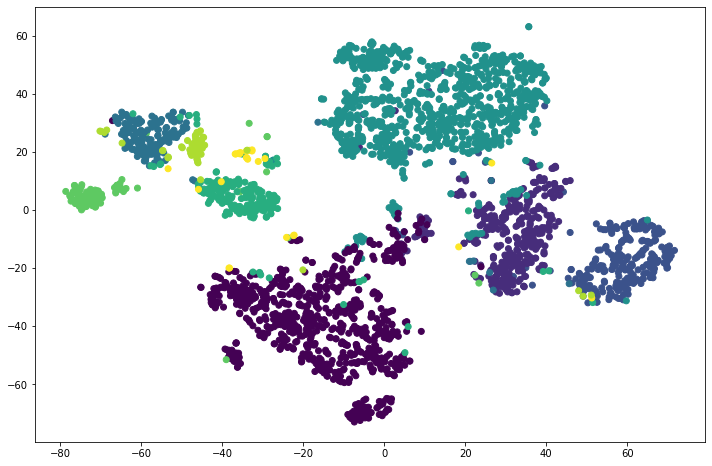

In [7]:
#Problem 2.2 PCA/tSNE

#TODO: Filter the count matrix to remove low-count genes
totals = np.sum(X, axis=0)
cutoff = 25
lowcount_filter = np.array([geneCount >= cutoff for geneCount in totals.tolist()])

highcount_genes = genes[lowcount_filter]
highcount_X = X[:, lowcount_filter]

#TODO: Add pseudocount and log transform count matrix (log(1 + X))
pseudocount_X = np.log(highcount_X + 1)

#TODO: Apply PCA on X and keep the 50 first PCs 
pca = PCA(n_components=50)
X_pca = pca.fit_transform(pseudocount_X)

#TODO: Apply 2-dimensional tSNE on the 50 PCs. Plot the 2-dimensional tSNE embedding and color each cell according to cell type
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X_pca)

label_set = list(set(labels))
colors = [label_set.index(l) for l in labels]

plt.figure(figsize=(12,8))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=colors)

In [14]:
#Problem 2.3 K-means
def distance_squared(a, b):
    total = 0
    for i in range(len(a)):
        total += (a[i] - b[i])**2
    return total

def kmeans_cluster(X, n_iter, k, verbose=False) :
    
    #TODO: Initialize k cluster centers by picking random data points and store them in matrix 'centers'
    #Hint: numpy.random.choice is good for picking random things from a list of things...
    
    #Currently, the cluster centers are just all-zero vectors
    centers = [X[n] for n in np.random.choice(range(len(X)), k, replace=False)]
    c_assignments = dict()
    
    #For each iteration, keep track of the cluster assignment of each data point in vector 'a'.
    a = np.zeros(X.shape[0], dtype=np.int)
    
    #For each iteration, store the mean within-cluster Sum-of-squares error in list 'mses'.
    mses = []
    
    for curr_iter in range(0, n_iter) :
        for c in range(k):
            c_assignments[c] = []
        
        if verbose :
            if curr_iter % 10 == 5 :
                print('K-means iteration ' + str(curr_iter))
        
        #TODO: Implement the E-step (Assign data points to clusters)
        for pt in range(len(X)):
            min_dist = float("inf")
            c_assign = None
            for c in range(k):
                dist = distance.euclidean(X[pt], centers[c])
                if(dist < min_dist):
                    min_dist = dist
                    c_assign = c
            c_assignments[c_assign].append(X[pt])
            a[pt] = c_assign
            
        
        #TODO: Implement the M-step (Re-estimate the cluster centers)
        for c in range(k):
            centers[c] = np.mean(c_assignments[c], axis=0)
        
        #TODO: Calculate and store the mean within-cluster Sum-of-squares error for this iteration
        cluster_mses = [np.mean([np.min([distance_squared(pt, ctr) for ctr in centers]) for pt in c_assignments[c]]) for c in range(k)]
        mse = np.mean(cluster_mses)
        mses.append(mse)
        
    return centers, a, mses


K-means iteration 5
K-means iteration 15
K-means iteration 25
K-means iteration 35
K-means iteration 45
K-means iteration 55
K-means iteration 65
K-means iteration 75
K-means iteration 85
K-means iteration 95


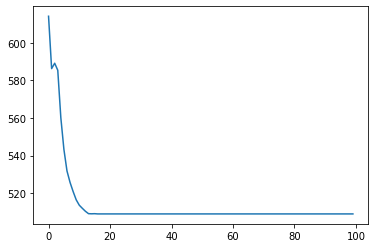

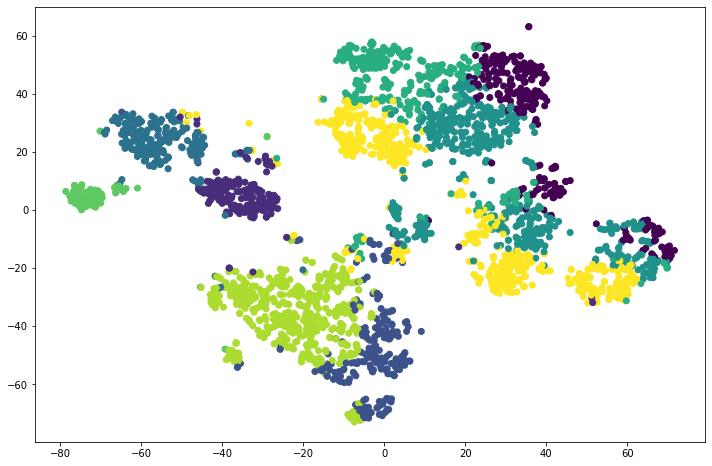

In [15]:
#TODO: Run K-means on the 50-PC dimensional count data, and plot (color) clusters over the tSNE embedding

means, assignments, mses = kmeans_cluster(X_pca, 100, 9, verbose=True)

#TODO: Plot the K-means within-cluster sum-of-squares error vs. iteration number
plt.plot(range(len(mses)), mses)

#TODO: Plot the 2D tSNE with k-means cluster assignments
plt.figure(figsize=(12,8))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=assignments)
